# Simple Attention over characters and tags with Attention layer trained 

Using cross entropy loss for training attention.  
If alignment for a target while predicting attention is not available, we don't consider the loss.  
Initially training both attention and sequence predictor, then only training sequence predictor.  

Todo:
1. The network has problem copying, implement copy mechanism.
2. Penalise model for paying attention to lemma characters when no alignment imformation for the target is available.

In [1]:
START_CHAR = '⏵'
STOP_CHAR = '⏹'
UNKNOWN_CHAR = '⊗'
UNKNOWN_TAG = '⊤'
PAD_CHAR = '₮'
PAD_TAG = '<PAD>'

In [2]:
aligner_path = './m2m-aligner/m2m-aligner'

In [3]:
%matplotlib inline

from itertools import zip_longest
import os
import pickle
import time
import subprocess

import Levenshtein
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F

In [4]:
def load_data(file_name):
    """Loads data.

    Args:
        file_name: path to file containing the data

    Returns:
        lemmas: list of lemma
        tags: list of tags
        inflected_forms: list of inflected form
    """

    with open(file_name, 'r', encoding='utf') as file:
        text = file.read()

    lemmas = []
    tags = []
    inflected_forms = []

    for line in text.split('\n')[:-1]:
        lemma, inflected_form, tag = line.split('\t')
        lemmas.append(lemma)
        inflected_forms.append(inflected_form)
        tags.append(tag) 

    return lemmas, tags, inflected_forms

def get_index_dictionaries(lemmas, tags, inflected_forms):
    """Returns char2index, index2char, tag2index

    Args:
        lemmas: list of lemma
        tags: list of tags
        inflected_forms: list of inflected form

    Returns: 
        char2index: a dictionary which maps character to index
        index2char: a dictionary which maps index to character
        tag2index: a ditionary which maps morphological tag to index 
    """

    unique_chars = set(''.join(lemmas) + ''.join(inflected_forms))
    unique_chars.update(START_CHAR, STOP_CHAR) # special start and end symbols
    unique_chars.update(UNKNOWN_CHAR) # special charcter for unknown word
    char2index = {}
    index2char = {}

    char2index[PAD_CHAR] = 0
    index2char[0] = PAD_CHAR
    
    for index, char in enumerate(unique_chars):
        char2index[char] = index + 1
        index2char[index + 1] = char

    unique_tags = set(';'.join(tags).split(';'))
    unique_tags.update(UNKNOWN_TAG)
    tag2index = {tag:index+1 for index, tag in enumerate(unique_tags)}
    tag2index[PAD_TAG] = 0

    return char2index, index2char, tag2index

def get_combined_index_dictionaries(lemmas, tags, inflected_forms):
    """Returns char2index, index2char

    Args:
        lemmas: list of lemma
        tags: list of tags
        inflected_forms: list of inflected form

    Returns: 
        char2index: a dictionary which maps inputs and  to index
        index2char: a dictionary which maps index to inputs
    """

    unique_chars = set(''.join(lemmas) + ''.join(inflected_forms))
    unique_chars.update(START_CHAR, STOP_CHAR, UNKNOWN_CHAR) # special start and end symbols  
    
    input2index = {}
    index2input = {}
    
    input2index[PAD_CHAR] = 0
    index2input[0] = PAD_CHAR
        
    for index, char in enumerate(unique_chars, start=1):
        input2index[char] = index
        index2input[index] = char
        
    char_vocab_length = len(input2index.keys())

    unique_tags = set(';'.join(tags).split(';'))
    unique_tags.add(UNKNOWN_TAG) # special character for unknown tags
    
    for index, char in enumerate(unique_tags, start=char_vocab_length):
        input2index[char] = index
        index2input[index] = char

    return input2index, index2input, char_vocab_length

def words_to_indices(words, char2index, tensor=False, start_char=False, stop_char=False):
    """Converts list of words to a list with list containing indices

    Args:
        words: list of words
        char2index: dictionary which maps character to index
        tensor: if to return a list of tensor  

    Returns:
        tensor: list of list/tensor containing indices for a sequence of characters
    """

    list_indices = []
    for word in words:
        word_indices = []
        if start_char:
            word_indices.append(char2index[START_CHAR])
        for char in word:
            if char in char2index.keys():
                word_indices.append(char2index[char])
            else:
                word_indices.append(char2index[UNKNOWN_CHAR])
        if stop_char:
            word_indices.append(char2index[STOP_CHAR])
        if tensor:
            word_indices = torch.Tensor(word_indices)
        list_indices.append(word_indices)

    return list_indices

def tag_to_vector(tags, tag2index):
    """Returns one hot representation of tags given a tag.

    Args:
        tags: list of string representation of tag (eg, V;IND;PRS;2;PL)

    Returns:
        tag_vectors: list of 1D tensors with one hot representation of tags 
    """

    tag_vectors = []
    for tag in tags:
        tag_vector = torch.zeros(len(tag2index))
        for tag_feature in tag.split(';'):
            if tag_feature in tag2index:
                tag_vector[tag2index[tag_feature]] = 1
            else:
                tag_vector[tag2index[UNKNOWN_TAG]] = 1
        tag_vectors.append(tag_vector)
    return tag_vectors

def tag_to_indices(tags, tag2index):
    """Converts list of tags to a list of lists containing indices

    Args:
        words: list of tags

    Returns:
        tensor: list of list containing indices of sub_tags
    """
    
    list_indices = []
    for tag in tags:
        tag_indices = []
        for sub_tag in tag.split(';'):
            if sub_tag in tag2index.keys():
                tag_indices.append(tag2index[sub_tag])
            else:
                tag_indices.append(tag2index[UNKNOWN_TAG])
        list_indices.append(tag_indices)

    return list_indices
    

def indices_to_word(indices, index2char):
    """Returns a word given list contaning indices of words

    Args:
        indices: list containing indices

    Returns:
        word: a string
    """

    return ''.join([index2char[index] for index in indices])[:-1]

def pad_lists(lists, pad_int, pad_len=None):
    """Pads lists in a list to make them of equal size"""
    
    if pad_len is None:
        pad_len = max([len(lst) for lst in lists])
    new_list = []
    for lst in lists:
        if len(lst) < pad_len:
            new_list.append(torch.tensor(lst + [pad_int] * (pad_len-len(lst))))
        else:
            new_list.append(torch.tensor(lst[:pad_len]))
    return torch.stack(new_list)

def merge_lists(lists1, lists2):
    """Add two list of lists."""
    
    merged_lists = []
    for list1, list2 in zip(lists1, lists2):
        merged_lists.append(list1 + list2)
    return merged_lists

def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

def accuracy(predictions, targets):
    correct_count = 0
    for prediction, target in zip(predictions, targets):
        if prediction == target:
            correct_count += 1
    return correct_count / len(predictions)

def average_distance(predictions, targets):
    total_distance = 0
    for prediction, target in zip(predictions, targets):
        total_distance += Levenshtein.distance(prediction, target)
    return total_distance / len(predictions)

def evaluate(predictions, targets):
    return accuracy(predictions, targets), average_distance(predictions, targets)

def showAttention(input_sentence, output_words, attentions, font=None):
    # https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
        
    # Set up figure with colorbar
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    font = FontProperties(fname=font, size=24)
    ax.set_xticklabels([''] + input_sentence, rotation=90, fontproperties=font)
    ax.set_yticklabels([''] + output_words, fontproperties=font)
    ax.tick_params(axis='both', which='major', pad=15)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    
def get_alignments(lemmas, inflected_forms, tags=None, normalise=False, maxX=1):
    """Gets alignments
    
    Args:
        training_data: path to training data
    """
    
    aligner_dir = os.path.split(aligner_path)[0]
    processed_file = open(os.path.join(aligner_dir, 'processed'), 'w', encoding='utf8')

    for lemma, inflected_form in zip(lemmas, inflected_forms):
        lemma = lemma.replace(' ', '*') + STOP_CHAR
        inflected_form = inflected_form.replace(' ', '*') + STOP_CHAR
        processed_file.write(' '.join(lemma) + '\t' + ' '.join(inflected_form) + '\n')

    processed_file.close()
    
    subprocess.run(aligner_path + ' --errorInFile --delY --maxX '+ str(maxX) + ' --maxY 1 -i ./m2m-aligner/processed -o ./m2m-aligner/output', shell=True)
    
    aligner_output = open(os.path.join(aligner_dir, 'output'), 'r', encoding='utf8')
    
    alignments = []

    for i, line in enumerate(aligner_output):
        if 'NO ALIGNMENT' in line:
            if tags is not None:
                word_alignment = np.zeros((len(inflected_forms[i]) + 1, len(lemmas[i]) + 2 + len(tags[i].split(';'))))
            else:
                word_alignment = np.zeros((len(inflected_forms[i]) + 1, len(lemmas[i]) + 2))
                
            if normalise:
                word_alignment = 1 / word_alignment.shape[1]
            alignments.append(word_alignment)
            continue

        aligned_lemma, aligned_inflected_form = line.split()
        index = 1
        lemma = START_CHAR + ''.join(aligned_lemma.split('|')[:-1]).replace('_', '').replace(':', '')
        inflected_form = ''.join(aligned_inflected_form.split('|')[:-1])
        if tags is not None:
            word_alignment = np.zeros((len(inflected_form), len(lemma) + len(tags[i].split(';'))))
        else:
            word_alignment = np.zeros((len(inflected_form), len(lemma)))

        for i, (lemma_char, word_char) in enumerate(zip(aligned_lemma.split('|')[:-1], aligned_inflected_form.split('|')[:-1])):
            if ':' in lemma_char:
                chars = len(lemma_char.split(':'))
                word_alignment[i, index:(index+chars)] = 1 / chars
                index += chars
            elif lemma_char != '_':
                word_alignment[i, index] = 1
                index += 1 
            else:
                if normalise:
                    word_alignment[i, :] = 1 / word_alignment.shape[1]
        alignments.append(word_alignment)    
        
    aligner_output.close()
            
    return alignments

In [5]:
language = 'middle-french'
dataset = 'low'

In [6]:
lemmas, tags, inflected_forms = load_data('./conll2018/task1/all/{}-train-{}'.format(language, dataset))

In [7]:
lemmas_train,lemmas_val, tags_train, tags_val, inflected_forms_train, inflected_forms_val = train_test_split(lemmas, tags, inflected_forms, test_size=0.2, random_state=42)

In [8]:
%time alignments_train = get_alignments(lemmas_train, inflected_forms_train, tags_train, normalise=False)

CPU times: user 0 ns, sys: 8 ms, total: 8 ms
Wall time: 40 ms


X: axis: ⏵practicquer⏹ ['⏵', 'p', 'r', 'a', 'c', 't', 'i', 'c', 'q', 'u', 'e', 'r', '⏹']
Y: axis: practicquant⏹ ['p', 'r', 'a', 'c', 't', 'i', 'c', 'q', 'u', 'a', 'n', 't', '⏹']


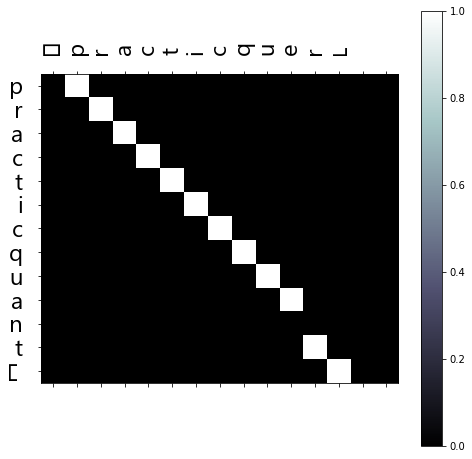

In [9]:
i = 5
lemma = START_CHAR + lemmas_train[i] + STOP_CHAR
inflected_form = inflected_forms_train[i] + STOP_CHAR

print('X: axis:', lemma, list(lemma))
print('Y: axis:', inflected_form, list(inflected_form))
showAttention(list(lemma), list(inflected_form), alignments_train[i], 'Nirmala.ttf')

In [10]:
input2index, index2input, char_vocab_size = get_combined_index_dictionaries(lemmas_train, tags_train, inflected_forms_train)


# Train

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
batch_size = 32
embedding_size = 300
hidden_size = 100
input_vocab_size = len(index2input.keys())

    class Attention(nn.Module):
        def __init__(self, hidden_size):
            # Custom

            super(Attention, self).__init__()
            self.linear = nn.Linear(3*hidden_size, 1)

        def forward(self, encoded_input, hidden_state, input_mask):
            src_len = encoded_input.shape[1]
            concat = torch.cat([encoded_input, hidden_state.transpose(0, 1).expand(-1, src_len, -1)], dim=2)
            attn_weights = F.tanh(self.linear(concat).squeeze())

            input_mask = input_mask.float()
            input_mask = torch.where(input_mask == 0, torch.zeros_like(input_mask), torch.ones_like(input_mask) * float('inf'))
            attn_weights = attn_weights - input_mask
            # attn_weights.data.masked_fill_(input_mask, float('-inf'))

            attn_weights = F.softmax(attn_weights, dim=1)
            return attn_weights

    class Attention(nn.Module):
        def __init__(self, hidden_size, intermediate_size=100):
            # concat scoring function - global attention 
            # https://arxiv.org/pdf/1508.04025.pdf

            super(Attention, self).__init__()
            if intermediate_size is None:
                intermediate_size = int(attention_input_size ** (1/2))
            self.W_a = nn.Linear(3*hidden_size, intermediate_size, bias=False)
            self.v_a = nn.Linear(intermediate_size, 1, bias=False)

        def forward(self, encoded_input, hidden_state, input_mask):
            src_len = encoded_input.shape[1]
            concat = torch.cat([encoded_input, hidden_state.transpose(0, 1).expand(-1, src_len, -1)], dim=2)
            attn_weights = F.tanh(self.W_a(concat))
            attn_weights = self.v_a(attn_weights).squeeze()
            attn_weights.data.masked_fill_(input_mask, float('-inf'))
            attn_weights = F.softmax(attn_weights, dim=1)
            return attn_weights

In [13]:
class Attention(nn.Module):
    def __init__(self, hidden_size, p=0.3):
        # general scoring function - global attention 
        # https://arxiv.org/pdf/1508.04025.pdf

        super(Attention, self).__init__()
        self.W_a = nn.Linear(2*hidden_size, hidden_size, bias=False)
        # self.dropout = nn.Dropout(p)

    def forward(self, encoded_input, hidden_state, input_mask):
        src_len = encoded_input.shape[1]
        attn_weights = torch.bmm(self.W_a(encoded_input), hidden_state.transpose(0, 1).transpose(1, 2)).squeeze()
        attn_weights.data.masked_fill_(input_mask, float('-inf'))
        # attn_weights = dropout(attn_weights)
        attn_weights = F.softmax(attn_weights, dim=1)
        return attn_weights

    class Attention(nn.Module):
        def __init__(self, attention_input_size, intermediate_size=100):
            super(Attention, self).__init__()

        def forward(self, encoded_input, hidden_state, input_mask):
            src_len = encoded_input.shape[1]
            attn_weights = (encoded_input * torch.cat([hidden_state.transpose(0, 1).expand(-1, src_len, -1), hidden_state.transpose(0, 1).expand(-1, src_len, -1)], dim=2)).sum(dim=2)

            input_mask = input_mask.float()
            input_mask = torch.where(input_mask == 0, torch.zeros_like(input_mask), torch.ones_like(input_mask) * float('inf'))
            attn_weights = attn_weights - input_mask
            #attn_weights.masked_fill_(input_mask, float('-inf'))

            attn_weights = F.softmax(attn_weights, dim=1)
            return attn_weights

In [14]:
Embedder = nn.Embedding(input_vocab_size, embedding_size, padding_idx=input2index[PAD_CHAR]).to(device)
Encoder = nn.LSTM(embedding_size, hidden_size, batch_first=True, bidirectional=True).to(device)
attention = Attention(hidden_size).to(device)
Decoder = nn.LSTM(embedding_size + 2 * hidden_size, hidden_size, batch_first=True).to(device)
linear1 = nn.Linear(3 * hidden_size, char_vocab_size - 1, ).to(device) # remove pad character option
dropout1 = torch.nn.Dropout(p=0)
log_softmax = nn.LogSoftmax(dim=2).to(device)
# attention_criterion = nn.MSELoss(size_average=False)
attention_criterion = nn.CrossEntropyLoss(ignore_index=-1)
criterion = nn.NLLLoss(ignore_index=-1)
params = list(Embedder.parameters()) + list(Encoder.parameters()) + list(Decoder.parameters()) + list(linear1.parameters()) + list(attention.parameters())

In [15]:
def test(lemmas_val, tags_val, inflected_forms_val, batch_size=32, attn_debug=False, max_pred_len=25):

    inflected_predicted = []
    inflected_forms_true = []
    if attn_debug:
        input_seq = []
        attn_weights_all = []
    output_indices = []

    for batch in grouper(zip(lemmas_val, tags_val, inflected_forms_val), batch_size):
        batch = list(filter(lambda x: x is not None, batch))
        lemmas, tags, inflected_forms = zip(*batch)

        lemmas_indices = words_to_indices(lemmas, input2index, start_char=True, stop_char=True)
        tags_indices = tag_to_indices(tags, input2index)    
        input_indices = merge_lists(lemmas_indices, tags_indices)

        # Sort by length of input sequence
        input_indices, inflected_forms = zip(*sorted(zip(input_indices, inflected_forms), key=lambda x: len(x[0]), reverse=True))        
        if attn_debug:
            input_seq += [[index2input[index] for index in input_indices1] for input_indices1 in input_indices]
        input_indices = [torch.tensor(lst) for lst in input_indices]

        input_tensor = pad_sequence(input_indices, padding_value=input2index[PAD_CHAR], batch_first=True).to(device)
        embedding = Embedder(input_tensor)
        lengths = [Tensor.shape[0] for Tensor in input_indices]
        packed_input = pack_padded_sequence(embedding, lengths, batch_first=True)
        encoded_packed_seq, (hidden, cell) = Encoder(packed_input)
        encoded_input = pad_packed_sequence(encoded_packed_seq, batch_first=True)[0]
        
        input_mask = input_tensor == 0
        # input_mask = torch.where(input_mask > 0, torch.zeros_like(input_mask), torch.ones_like(input_mask) * float('inf')) 


        # Decode
        hidden_state = hidden[0,:,:] + hidden[1,:,:]
        hidden_state = hidden_state.unsqueeze(0)
        cell_state = torch.zeros(1, len(lengths), hidden_size).to(device)

        decoder_input = torch.tensor([input2index[START_CHAR]] * len(lengths)).to(device)
        decoder_input = Embedder(decoder_input).unsqueeze(1)


        outputs = []
        attn_weights_sequence = []
        for seq in range(0, max_pred_len):
            attn_weights = attention(encoded_input, hidden_state, input_mask)
            if attn_debug:
                attn_weights_sequence.append(attn_weights)
            context = torch.bmm(attn_weights.unsqueeze(1), encoded_input).squeeze()

            decoder_input_concat = torch.cat([context.unsqueeze(1), decoder_input], dim=2)

            output, (hidden_state, cell_state) = Decoder(decoder_input_concat, (hidden_state, cell_state))
            output = F.relu(linear1(torch.cat([hidden_state, context.unsqueeze(0)], dim=2)))            
            decoder_input = Embedder(output.argmax(dim=2) + 1).transpose(0, 1)
            outputs.append(output.squeeze())

        if attn_debug:
            attn_weights_sequence = torch.stack(attn_weights_sequence, dim=1)
            attn_weights_all.append(attn_weights_sequence)
        output_indices.append(torch.stack(outputs).argmax(dim=2))
        inflected_forms_true += inflected_forms

    output_indices = torch.cat(output_indices, dim=1).transpose(0, 1).cpu().numpy()
    for indices in output_indices:
        inflected_predicted.append(''.join([index2input[index + 1] for index in indices]).split(STOP_CHAR)[0])
            
    if attn_debug:
        max_src_len = max([x.shape[2] for x in attn_weights_all])
        for i in range(len(attn_weights_all)):
            attn_weights = attn_weights_all[i]
            batch_size = attn_weights.shape[0]
            src_len = attn_weights.shape[2]
            attn_weights_all[i] = torch.zeros(batch_size, max_pred_len, max_src_len)
            attn_weights_all[i][:,:,:src_len] = attn_weights
        attn_weights_all = torch.cat(attn_weights_all, dim=0)
        return inflected_predicted, input_seq, attn_weights_all
    else:
        return inflected_predicted, inflected_forms_true

In [16]:
def train(lemmas_train, tags_train, inflected_forms_train, epochs=1, lamda=1):
    
    start_time = time.time()

    for epoch in range(epochs):

        epoch_loss = 0
        epoch_char_loss = 0
        epoch_attention_loss = 0

        for batch in grouper(zip(lemmas_train, tags_train, inflected_forms_train, alignments_train), batch_size):
            batch = list(filter(lambda x: x is not None, batch))
            lemmas, tags, inflected_forms, alignments = zip(*batch)


            lemmas_indices = words_to_indices(lemmas, input2index, start_char=True, stop_char=True)
            tags_indices = tag_to_indices(tags, input2index)    
            inflected_forms_indices = words_to_indices(inflected_forms, input2index)
            input_indices = merge_lists(lemmas_indices, tags_indices)

            # Sort by length of input sequence
            input_indices, inflected_forms_indices, alignments = zip(*sorted(zip(input_indices, inflected_forms_indices, alignments), key=lambda x: len(x[0]), reverse=True))
            input_indices = [torch.tensor(lst) for lst in input_indices]

            optimiser.zero_grad()

            input_tensor = pad_sequence(input_indices, padding_value=input2index[PAD_CHAR], batch_first=True).to(device)
            embedding = Embedder(input_tensor)
            lengths = [Tensor.shape[0] for Tensor in input_indices]
            packed_input = pack_padded_sequence(embedding, lengths, batch_first=True)
            encoded_packed_seq, (hidden, cell) = Encoder(packed_input)
            encoded_input = pad_packed_sequence(encoded_packed_seq, batch_first=True)[0]

            input_mask = input_tensor == 0
            # input_mask = torch.where(input_mask > 0, torch.zeros_like(input_mask), torch.ones_like(input_mask) * float('inf')) 

            # Decode
            hidden_state = hidden[0,:,:] + hidden[1,:,:]
            hidden_state = hidden_state.unsqueeze(0)
            cell_state = torch.zeros(1, len(lengths), hidden_size).to(device)

            target = pad_lists([lst + [input2index[STOP_CHAR]] for lst in inflected_forms_indices], input2index[PAD_CHAR]).to(device)    
            target = target - 1

            decoder_input = pad_lists(inflected_forms_indices, input2index[PAD_CHAR]).to(device)
            decoder_input = torch.cat([torch.tensor([input2index[START_CHAR]] * len(lengths)).unsqueeze(1).to(device), decoder_input], dim=1)
            decoder_input = Embedder(decoder_input)

            char_loss = 0
            attention_loss = 0

            max_length = target.shape[1]
            
            # get alignment matrix
            max_src_len = lengths[0]
            bsz = len(alignments)
            alignments_batched = np.zeros((bsz, max_length, max_src_len))
            for i, alignment in enumerate(alignments):
                alignments_batched[i, :alignment.shape[0], :alignment.shape[1]] = alignment
            alignments_batched = torch.from_numpy(alignments_batched).float().to(device)            
            
            for seq in range(0, max_length):
                attn_weights = attention(encoded_input, hidden_state, input_mask)
                attention_target = alignments_batched[:, seq, :].argmax(dim=1).detach().masked_fill(alignments_batched[:, seq, :].sum(dim=1) == 0, -1)
                # loss += lamda * attention_criterion(attn_weights, alignments_batched[:, seq, :]) MSE
                attention_loss += attention_criterion(attn_weights, attention_target)
                context = torch.bmm(attn_weights.unsqueeze(1), encoded_input).squeeze()

                decoder_input_concat = torch.cat([context.unsqueeze(1), decoder_input[:,seq,:].unsqueeze(1)], dim=2)

                output, (hidden_state, cell_state) = Decoder(decoder_input_concat, (hidden_state, cell_state))
                output = F.relu(linear1(torch.cat([hidden_state, context.unsqueeze(0)], dim=2)))
                output = dropout1(output)
                output = log_softmax(output).squeeze()
                char_loss += criterion(output, target[:,seq])

            loss = char_loss + lamda * attention_loss
            epoch_loss += loss.item()
            epoch_attention_loss += attention_loss.item() 
            epoch_char_loss += char_loss.item()
            loss.backward()
            optimiser.step()

        print("Epoch: {}/{}\tTime: {:.2f}s\tLoss: {:.4f}\tALoss: {:.4f}\tCLoss: {:.4f}\tAcc: {:.4f}\tLD: {:.4f} ".format(epoch+1, epochs, time.time() - start_time, epoch_loss / len(lemmas_train), epoch_attention_loss / len(lemmas_train), epoch_char_loss / len(lemmas_train), *evaluate(*test(lemmas_val, tags_val, inflected_forms_val))))

In [17]:
optimiser = optim.Adagrad(params, lr=0.01)

In [18]:
train(lemmas_train, tags_train, inflected_forms_train, epochs=20, lamda=2)

Epoch: 1/20	Time: 0.07s	Loss: 4.5232	ALoss: 1.4469	CLoss: 1.6294	Acc: 0.0000	LD: 8.4000 
Epoch: 2/20	Time: 0.14s	Loss: 4.0810	ALoss: 1.3632	CLoss: 1.3546	Acc: 0.0000	LD: 7.9500 
Epoch: 3/20	Time: 0.20s	Loss: 3.7706	ALoss: 1.3115	CLoss: 1.1477	Acc: 0.0000	LD: 7.8000 
Epoch: 4/20	Time: 0.27s	Loss: 3.5619	ALoss: 1.2710	CLoss: 1.0199	Acc: 0.0000	LD: 7.3000 
Epoch: 5/20	Time: 0.34s	Loss: 3.4783	ALoss: 1.2562	CLoss: 0.9660	Acc: 0.0000	LD: 7.3000 
Epoch: 6/20	Time: 0.40s	Loss: 3.3244	ALoss: 1.2205	CLoss: 0.8834	Acc: 0.0000	LD: 6.9000 
Epoch: 7/20	Time: 0.47s	Loss: 3.2378	ALoss: 1.2064	CLoss: 0.8250	Acc: 0.0000	LD: 7.0000 
Epoch: 8/20	Time: 0.54s	Loss: 3.1431	ALoss: 1.1842	CLoss: 0.7747	Acc: 0.0000	LD: 6.3000 
Epoch: 9/20	Time: 0.62s	Loss: 3.0642	ALoss: 1.1698	CLoss: 0.7247	Acc: 0.0000	LD: 7.4000 
Epoch: 10/20	Time: 0.68s	Loss: 2.9790	ALoss: 1.1516	CLoss: 0.6759	Acc: 0.0000	LD: 8.1500 
Epoch: 11/20	Time: 0.75s	Loss: 2.9370	ALoss: 1.1459	CLoss: 0.6452	Acc: 0.0000	LD: 6.2000 
Epoch: 12/20	Time: 

In [19]:
optimiser = optim.Adagrad(params, lr=0.001)

In [20]:
train(lemmas_train, tags_train, inflected_forms_train, epochs=1000, lamda=0)

Epoch: 1/1000	Time: 0.06s	Loss: 0.4045	ALoss: 1.0995	CLoss: 0.4045	Acc: 0.0000	LD: 6.6500 
Epoch: 2/1000	Time: 0.12s	Loss: 0.3901	ALoss: 1.1008	CLoss: 0.3901	Acc: 0.0000	LD: 7.0500 
Epoch: 3/1000	Time: 0.19s	Loss: 0.3820	ALoss: 1.1004	CLoss: 0.3820	Acc: 0.0000	LD: 6.6000 
Epoch: 4/1000	Time: 0.26s	Loss: 0.3737	ALoss: 1.1006	CLoss: 0.3737	Acc: 0.0000	LD: 6.8500 
Epoch: 5/1000	Time: 0.32s	Loss: 0.3679	ALoss: 1.1010	CLoss: 0.3679	Acc: 0.0000	LD: 6.7500 
Epoch: 6/1000	Time: 0.39s	Loss: 0.3611	ALoss: 1.1017	CLoss: 0.3611	Acc: 0.0000	LD: 6.8500 
Epoch: 7/1000	Time: 0.46s	Loss: 0.3569	ALoss: 1.1016	CLoss: 0.3569	Acc: 0.0000	LD: 6.9500 
Epoch: 8/1000	Time: 0.52s	Loss: 0.3525	ALoss: 1.1016	CLoss: 0.3525	Acc: 0.0000	LD: 7.4500 
Epoch: 9/1000	Time: 0.59s	Loss: 0.3491	ALoss: 1.1017	CLoss: 0.3491	Acc: 0.0000	LD: 7.4000 
Epoch: 10/1000	Time: 0.66s	Loss: 0.3455	ALoss: 1.1017	CLoss: 0.3455	Acc: 0.0000	LD: 7.5000 
Epoch: 11/1000	Time: 0.73s	Loss: 0.3423	ALoss: 1.1012	CLoss: 0.3423	Acc: 0.0000	LD: 7.350

Epoch: 92/1000	Time: 6.19s	Loss: 0.2632	ALoss: 1.0997	CLoss: 0.2632	Acc: 0.0000	LD: 6.3000 
Epoch: 93/1000	Time: 6.26s	Loss: 0.2630	ALoss: 1.0997	CLoss: 0.2630	Acc: 0.0000	LD: 6.3000 
Epoch: 94/1000	Time: 6.33s	Loss: 0.2627	ALoss: 1.0997	CLoss: 0.2627	Acc: 0.0000	LD: 6.2500 
Epoch: 95/1000	Time: 6.39s	Loss: 0.2623	ALoss: 1.0998	CLoss: 0.2623	Acc: 0.0000	LD: 6.3000 
Epoch: 96/1000	Time: 6.46s	Loss: 0.2618	ALoss: 1.0998	CLoss: 0.2618	Acc: 0.0000	LD: 6.2500 
Epoch: 97/1000	Time: 6.53s	Loss: 0.2616	ALoss: 1.0999	CLoss: 0.2616	Acc: 0.0000	LD: 6.1500 
Epoch: 98/1000	Time: 6.60s	Loss: 0.2618	ALoss: 1.0996	CLoss: 0.2618	Acc: 0.0000	LD: 6.3000 
Epoch: 99/1000	Time: 6.66s	Loss: 0.2614	ALoss: 1.0998	CLoss: 0.2614	Acc: 0.0000	LD: 6.2000 
Epoch: 100/1000	Time: 6.73s	Loss: 0.2608	ALoss: 1.0998	CLoss: 0.2608	Acc: 0.0000	LD: 6.1500 
Epoch: 101/1000	Time: 6.80s	Loss: 0.2604	ALoss: 1.0999	CLoss: 0.2604	Acc: 0.0000	LD: 6.2000 
Epoch: 102/1000	Time: 6.87s	Loss: 0.2600	ALoss: 1.0999	CLoss: 0.2600	Acc: 0.00

Epoch: 180/1000	Time: 12.13s	Loss: 0.2461	ALoss: 1.0984	CLoss: 0.2461	Acc: 0.0000	LD: 5.9500 
Epoch: 181/1000	Time: 12.20s	Loss: 0.2459	ALoss: 1.0986	CLoss: 0.2459	Acc: 0.0000	LD: 5.9500 
Epoch: 182/1000	Time: 12.27s	Loss: 0.2459	ALoss: 1.0982	CLoss: 0.2459	Acc: 0.0000	LD: 5.8500 
Epoch: 183/1000	Time: 12.33s	Loss: 0.2458	ALoss: 1.0984	CLoss: 0.2458	Acc: 0.0000	LD: 5.9000 
Epoch: 184/1000	Time: 12.40s	Loss: 0.2455	ALoss: 1.0986	CLoss: 0.2455	Acc: 0.0000	LD: 5.8500 
Epoch: 185/1000	Time: 12.47s	Loss: 0.2456	ALoss: 1.0982	CLoss: 0.2456	Acc: 0.0000	LD: 5.8000 
Epoch: 186/1000	Time: 12.53s	Loss: 0.2455	ALoss: 1.0984	CLoss: 0.2455	Acc: 0.0000	LD: 5.9000 
Epoch: 187/1000	Time: 12.60s	Loss: 0.2453	ALoss: 1.0986	CLoss: 0.2453	Acc: 0.0000	LD: 6.0500 
Epoch: 188/1000	Time: 12.67s	Loss: 0.2453	ALoss: 1.0983	CLoss: 0.2453	Acc: 0.0000	LD: 6.0000 
Epoch: 189/1000	Time: 12.74s	Loss: 0.2452	ALoss: 1.0984	CLoss: 0.2452	Acc: 0.0000	LD: 6.1500 
Epoch: 190/1000	Time: 12.81s	Loss: 0.2449	ALoss: 1.0987	CLos

Epoch: 268/1000	Time: 18.07s	Loss: 0.2396	ALoss: 1.0991	CLoss: 0.2396	Acc: 0.0000	LD: 5.6500 
Epoch: 269/1000	Time: 18.13s	Loss: 0.2396	ALoss: 1.0993	CLoss: 0.2396	Acc: 0.0000	LD: 5.6000 
Epoch: 270/1000	Time: 18.20s	Loss: 0.2395	ALoss: 1.0991	CLoss: 0.2395	Acc: 0.0000	LD: 5.6500 
Epoch: 271/1000	Time: 18.27s	Loss: 0.2397	ALoss: 1.0991	CLoss: 0.2397	Acc: 0.0000	LD: 5.6000 
Epoch: 272/1000	Time: 18.33s	Loss: 0.2396	ALoss: 1.0992	CLoss: 0.2396	Acc: 0.0000	LD: 5.6000 
Epoch: 273/1000	Time: 18.40s	Loss: 0.2394	ALoss: 1.0993	CLoss: 0.2394	Acc: 0.0000	LD: 5.6000 
Epoch: 274/1000	Time: 18.47s	Loss: 0.2393	ALoss: 1.0992	CLoss: 0.2393	Acc: 0.0000	LD: 5.6000 
Epoch: 275/1000	Time: 18.54s	Loss: 0.2394	ALoss: 1.0992	CLoss: 0.2394	Acc: 0.0000	LD: 5.5500 
Epoch: 276/1000	Time: 18.60s	Loss: 0.2393	ALoss: 1.0993	CLoss: 0.2393	Acc: 0.0000	LD: 5.5500 
Epoch: 277/1000	Time: 18.67s	Loss: 0.2392	ALoss: 1.0993	CLoss: 0.2392	Acc: 0.0000	LD: 5.6000 
Epoch: 278/1000	Time: 18.74s	Loss: 0.2392	ALoss: 1.0991	CLos

KeyboardInterrupt: 

In [21]:
print("Train accuracy:", evaluate(*test(lemmas_train, tags_train, inflected_forms_train)), "Validation accuracy: ", evaluate(*test(lemmas_val, tags_val, inflected_forms_val)))

Train accuracy: (0.1625, 2.9625) Validation accuracy:  (0.0, 5.2)


# Visualising

In [22]:
pred, input_seq, attn_weights = test(lemmas_val[:100], tags_val[:100], inflected_forms_val[:100], batch_size=32, attn_debug=True)

In [23]:
%time alignments_train_val = get_alignments(lemmas_train + lemmas_val, inflected_forms_train + inflected_forms_val, tags_train + tags_val, normalise=False)

CPU times: user 0 ns, sys: 20 ms, total: 20 ms
Wall time: 82.4 ms


X: axis: ⏵, a, c, c, o, m, p, a, i, g, n, e, r, ⏹, V, 2, SG, IND, FUT accompaigner
Y: axis: a, c, c, o, m, p, a, i, s, e, e accompaisee


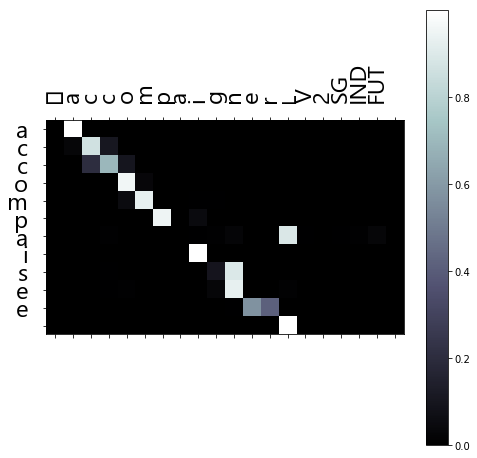

X: axis: ⏵accompaigner⏹ ['⏵', 'a', 'c', 'c', 'o', 'm', 'p', 'a', 'i', 'g', 'n', 'e', 'r', '⏹']
Y: axis: accompaigneras⏹ ['a', 'c', 'c', 'o', 'm', 'p', 'a', 'i', 'g', 'n', 'e', 'r', 'a', 's', '⏹']


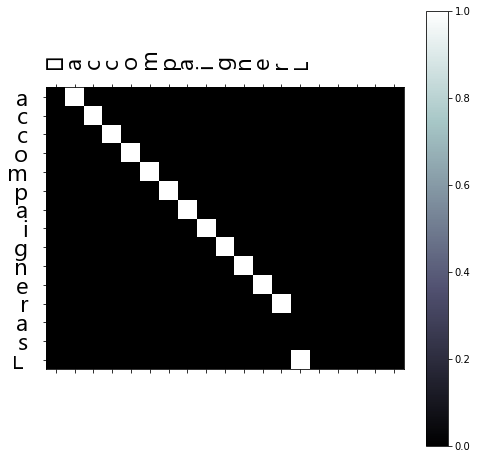

In [29]:
i = 1
print('X: axis:', ', '.join(list(input_seq[i])), ''.join(input_seq[i]).split(STOP_CHAR)[0][1:])
print('Y: axis:', ', '.join(list(pred[i])), pred[i])
showAttention(input_seq[i], list(pred[i]), attn_weights[i, :len(pred[i]) + 1].cpu().detach().numpy(), 'Nirmala.ttf')

j = lemmas_val.index(''.join(input_seq[i])[1:].split(STOP_CHAR)[0])
lemma = START_CHAR + lemmas_val[j] + STOP_CHAR
inflected_form = inflected_forms_val[j] + STOP_CHAR

print('X: axis:', lemma, list(lemma))
print('Y: axis:', inflected_form, list(inflected_form))
showAttention(list(lemma), list(inflected_form), alignments_train_val[len(lemmas_train):][j], 'Nirmala.ttf')

Has somewhat learnt attention but can't focus on tags.

In [ ]:
#list(zip(*test(lemmas_val, tags_val, inflected_forms_val)))

# Development Dataset

In [26]:
lemmas_dev, tags_dev, inflected_forms_dev = load_data('./conll2018/task1/all/{}-dev'.format(language))

In [27]:
evaluate(*test(lemmas_dev, tags_dev, inflected_forms_dev))

(0.013, 5.234)

middle-french/low: (0.013, 5.234), not optimised

In [28]:
for prediction, truth in zip(*test(lemmas_dev, tags_dev, inflected_forms_dev)):
    print("Prediction: {}\tTruth: {}".format(prediction, truth))

Prediction: escooveiie	Truth: enconvenencierois
Prediction: pourpesseroye	Truth: pourpensiez
Prediction: accompaiquee	Truth: accompaignerez
Prediction: ariccois	Truth: allaictois
Prediction: daiousteryee	Truth: adioustoyent
Prediction: mesaassoys	Truth: menassoys
Prediction: pourforce	Truth: pourforce
Prediction: pruuie	Truth: approuche
Prediction: effectuasses	Truth: effectuas
Prediction: eappereries	Truth: evaporiez
Prediction: besoiieeroye	Truth: besoigneroient
Prediction: destieroys	Truth: desista
Prediction: baptisses	Truth: baptisastes
Prediction: esaassoys	Truth: essayoys
Prediction: afferes	Truth: afferma
Prediction: rramois	Truth: armoia
Prediction: esiiterois	Truth: essilieroys
Prediction: esporerierierierierierier	Truth: exploreriez
Prediction: aroirois	Truth: aornois
Prediction: espereriass	Truth: esperassiez
Prediction: evvittierei	Truth: evityez
Prediction: qaisseroys	Truth: gaigna
Prediction: escaacceoyt	Truth: eslancent
Prediction: bayysas	Truth: baysassions
Prediction: